# Machine Learning demonstration

Start by importing the required libraries. For machine learning we are using scikit-learn: http://scikit-learn.org/

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
import pickle

For data analysis we are using Pandas: http://pandas.pydata.org/

In [2]:
import numpy as np # numberic processing library
import pandas as pd # data analysis library

Data is stored in MongoDB (https://www.mongodb.com/) and accessed using pymongo (https://api.mongodb.com/python/current/)

For plotting we are using matplotlib: http://matplotlib.org/

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [23]:
from pymongo import MongoClient # API to MongoDB

# read the apartments into Pandas dataframe
client = MongoClient()
db = client.housing_outliers
collection = db.apartments
cursor = db.apartments.find({})
df =  pd.DataFrame(list(cursor))
df[0:10][['city','area','year','desc','floor','size','price','rooms']] # show a subset of data

,city,area,year,desc,floor,size,price,rooms
0,Espoo,Lintuvaara,1988,"1h,kk,s,parveke",3,35.0,137000.0,1
1,Espoo,Leppävaara,1985,"1h,k,m.alkovi,s,p",2,34.5,152000.0,1
2,Espoo,Puustellinmäki,1994,1h+kk+s,1,39.0,144500.0,1
3,Espoo,Lähderanta,1962,"1h,kk,kh",3,27.0,118000.0,1
4,Espoo,Lähderanta,1962,1h+kk+kh,2,27.0,105500.0,1
5,Espoo,Laaksolahti,1967,"1h, kk",1,28.0,110000.0,1
6,Espoo,Ymmersta,2017,1h+kt,2,38.0,164630.0,1
7,Espoo,Ymmersta,2017,1h+kt,3,38.0,169390.0,1
8,Espoo,Ymmersta,2017,1h+kt,6,31.0,166080.0,1
9,Espoo,Ymmersta,2017,1h+kt,5,31.0,159140.0,1


Scikit-learn algorithms operate with numberic data only so lets encode all strings into ints and drop columns that cannot be used from the dataset.

In [24]:
# massage the data for use with ML algorithms: drop empty data and make strings into numbers
areacode_le = LabelEncoder()
df.areacode = areacode_le.fit_transform(df.areacode)

# Drop entries that have missing year
df = df[df['year'].map(len) == 4]
df.year = df.year.astype(int)

# drop columns that cannot be used with our model
df = df[['areacode','size','price','year','rooms','elevator','condition','floor','floors']]
df[0:10]

,areacode,size,price,year,rooms,elevator,condition,floor,floors
0,65,35.0,137000.0,1988,1,1,3,3,5
1,65,34.5,152000.0,1985,1,0,2,2,3
2,65,39.0,144500.0,1994,1,0,2,1,3
3,66,27.0,118000.0,1962,1,0,1,3,3
4,66,27.0,105500.0,1962,1,1,2,2,5
5,66,28.0,110000.0,1967,1,0,2,1,3
6,67,38.0,164630.0,2017,1,1,1,2,7
7,67,38.0,169390.0,2017,1,1,1,3,7
8,67,31.0,166080.0,2017,1,1,1,6,7
9,67,31.0,159140.0,2017,1,1,1,5,7


We are using supervised learning so let's split the data into training set that will be matched against the test set.

In [25]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'],axis=1), df.price, test_size=0.2, random_state=20)
len(X_train),len(X_test)

(589, 148)

Try out a couple different estimators and examine error.

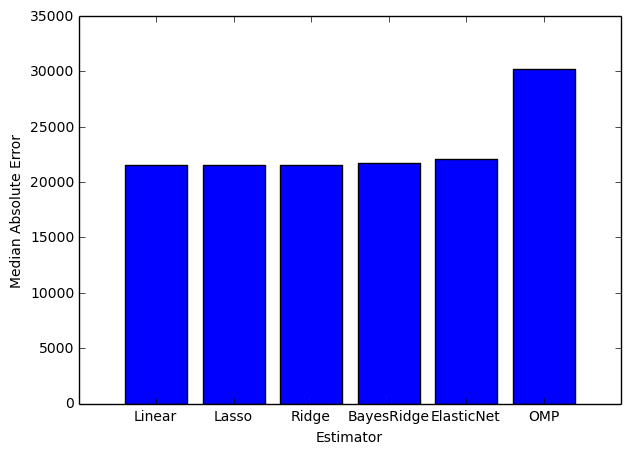

In [26]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Not very good results, so lets give GradientBoostingRegressor a chance.

In [27]:
n_est = 3000

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 8 ],
    "learning_rate": [ 0.001 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
print "Best estimator error :" + str(metrics.median_absolute_error(y_test, best.predict(X_test)))

Best estimator error :9387.36807674


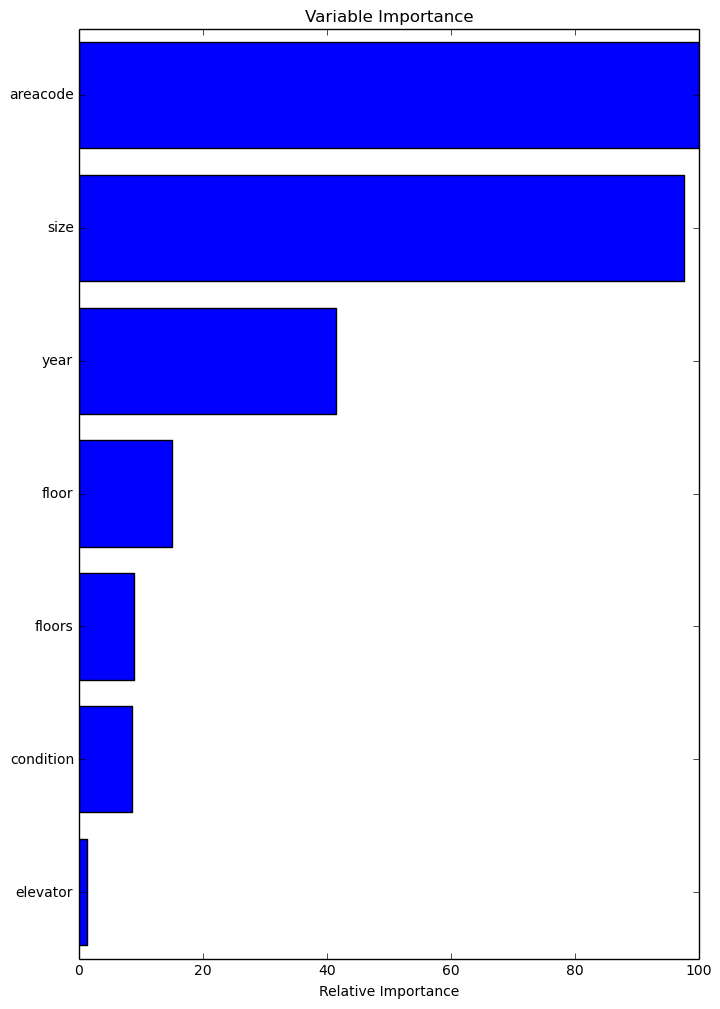

In [9]:
feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

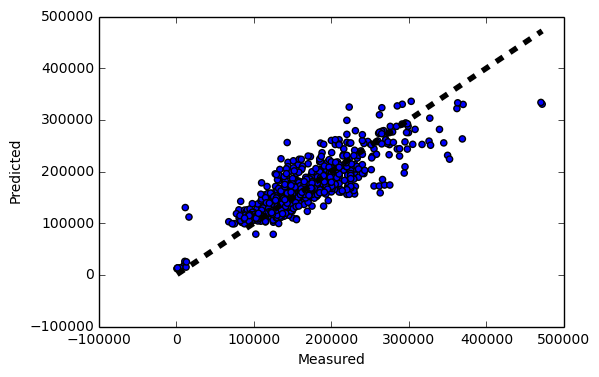

In [10]:
y = df.price
predicted = cross_val_predict(best, df.drop(['price'],axis=1).as_matrix(), y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [12]:
f = open ('model.dat','wb')
model = {'predictor':best,'areacode_encoder':areacode_le}
f.write(pickle.dumps(model))
f.close()

In [17]:
feature = np.array([65,35.0,1988,1,3,3,5])
best.predict(feature.reshape(1,-1))

array([ 150949.79616312])

In [16]:
f = open('model.dat','rb')
s = f.read()
model = pickle.loads(s)
predictor = model['predictor']
areacode_le = model['areacode_encoder']

In [76]:

areacode_le.inverse_transform([65])

array([u'02650'], dtype=object)

In [18]:
X_test.columns

Index([u'areacode', u'size', u'year', u'elevator', u'condition', u'floor',
       u'floors'],
      dtype='object')

In [20]:
areacode_le.transform(['02650'])

array([65])

In [28]:
df.condition

0      3
1      2
2      2
3      1
4      2
5      2
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     1
15     1
16     1
17     1
18     2
19     2
20     3
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     2
      ..
707    1
708    2
709    2
710    0
711    1
712    1
713    2
714    2
715    2
716    2
717    0
718    2
719    1
720    1
721    2
722    2
723    2
724    2
725    2
726    2
727    1
728    2
729    2
730    1
731    2
732    2
733    1
734    2
735    1
736    1
Name: condition, dtype: int64